In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np # needed for the last charts

# path to the json output from the benchmarks
# json_path = "../nvidia-h100-working-pipecg-unoptimised/benchmark_output_smarter.json"
json_path = "../nvidia-h100-working-pipecg-unoptimised-big-lessiter/benchmark_output_big_10rep.json"
with open(json_path, 'r') as f:
    json_data = f.read()
data = json.loads(json_data)

In [2]:
# list all the matrices
for entry in data:
    print(f"\"{entry['filename']}\",")

"benchmark_matrices_big/MM/Schmid/thermal2/thermal2.mtx",
"benchmark_matrices_big/MM/Schmid/thermal2/thermal2_b.mtx",
"benchmark_matrices_big/MM/AMD/G3_circuit/G3_circuit.mtx",


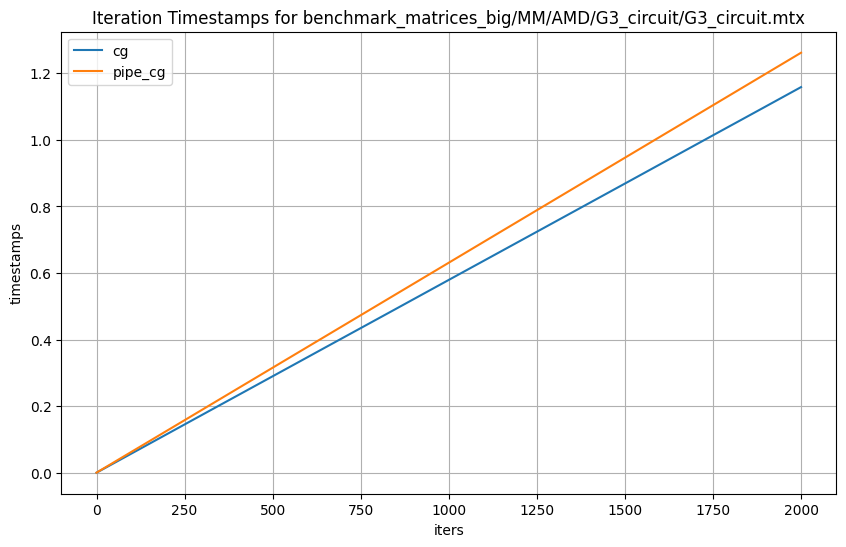

In [3]:
# plot timestamps for different solvers (not really useful)
target_filename = "benchmark_matrices_big/MM/AMD/G3_circuit/G3_circuit.mtx"

solvers_to_plot = ['cg', 'pipe_cg']

solver_data = {}
test_case_found = False

for entry in data:
    if entry["filename"] == target_filename:
        test_case_found = True
        for solver_name in solvers_to_plot:
            if solver_name in entry["solver"] and "iteration_timestamps" in entry["solver"][solver_name]:
                solver_data[solver_name] = entry["solver"][solver_name]["iteration_timestamps"]
        break

if not test_case_found:
    print(f"error: filename '{target_filename}' not found in the data.")
else:
    plt.figure(figsize=(10, 6))

    for solver_name, timestamps in solver_data.items():
        iterations = range(len(timestamps))
        plt.plot(iterations, timestamps, label=solver_name)
    plt.xlabel('iters')
    plt.ylabel('timestamps')
    plt.title(f'Iteration Timestamps for {target_filename}')
    plt.legend()
    plt.grid(True)
    plt.show()

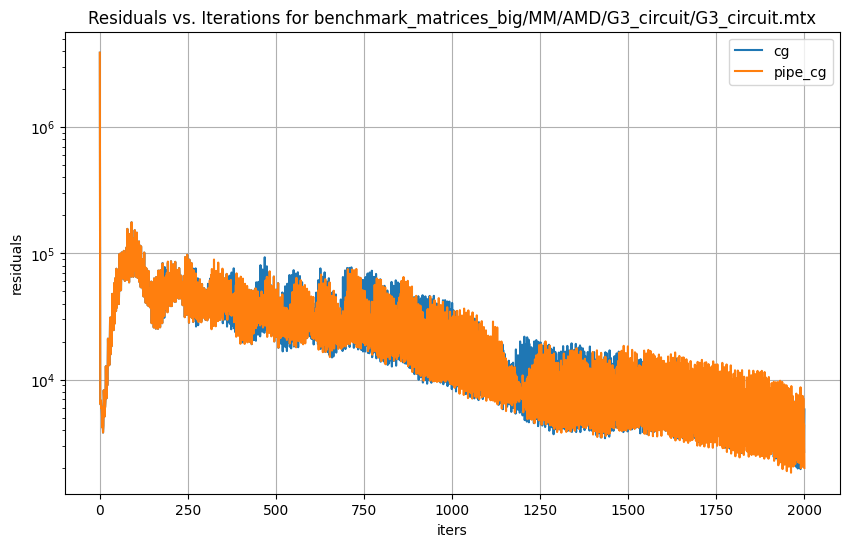

In [4]:
# plot residuals for different solvers
target_filename = "benchmark_matrices_big/MM/AMD/G3_circuit/G3_circuit.mtx"

solvers_to_plot = ['cg', 'pipe_cg']

solver_data_residuals = {}

for entry in data:
    if entry["filename"] == target_filename:
        for solver_name in solvers_to_plot:
            if solver_name in entry["solver"]:
                if "true_residuals" in entry["solver"][solver_name]:
                    solver_data_residuals[solver_name] = entry["solver"][solver_name]["true_residuals"]
                elif "recurrent_residuals" in entry["solver"][solver_name]:
                    solver_data_residuals[solver_name] = entry["solver"][solver_name]["recurrent_residuals"]
        break

plt.figure(figsize=(10, 6))

for solver_name, residuals in solver_data_residuals.items():
    iterations = range(len(residuals))
    plt.plot(iterations, residuals, label=solver_name)

plt.xlabel('iters')
plt.ylabel('residuals')
plt.title(f'Residuals vs. Iterations for {target_filename}')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

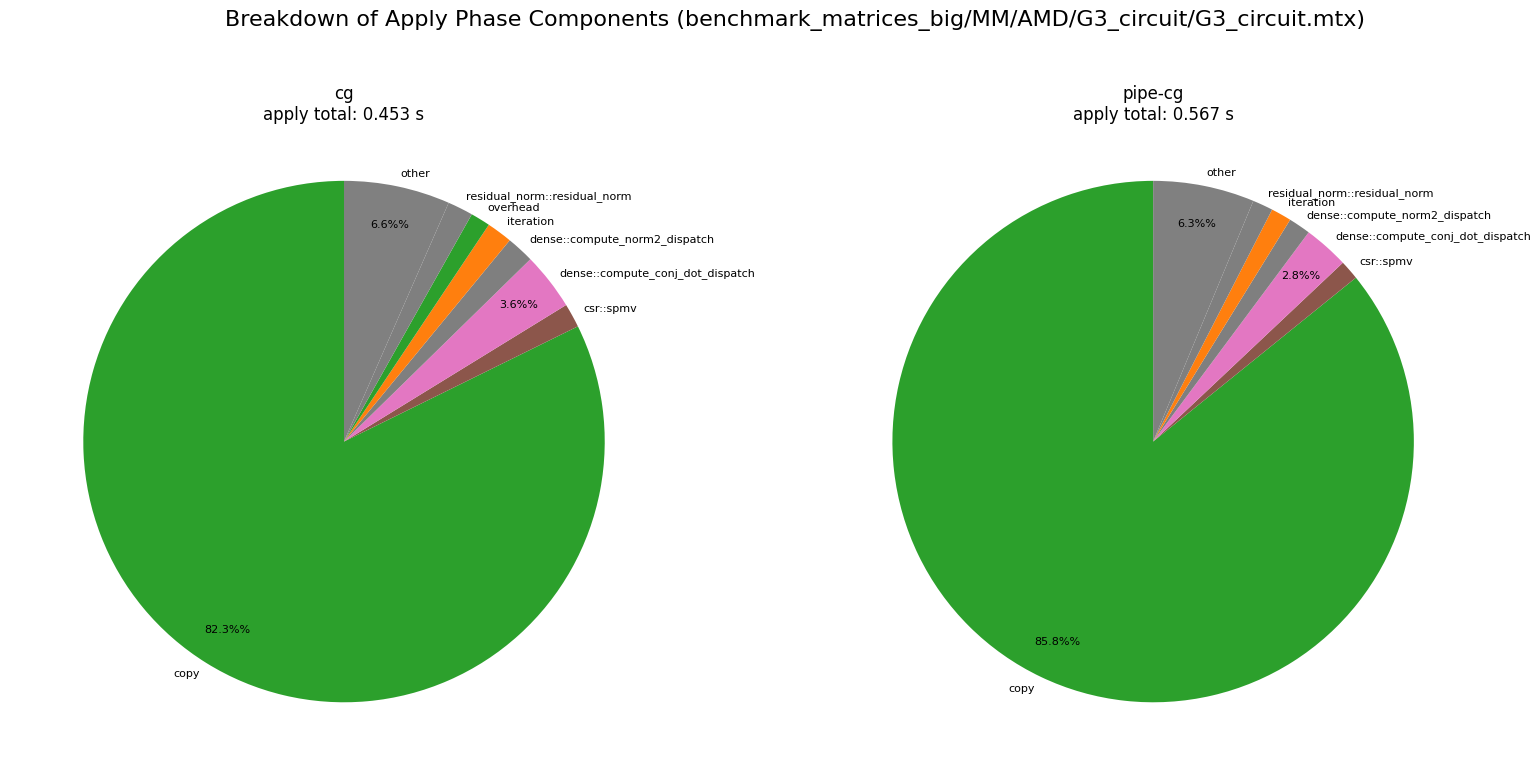

In [10]:
# pie chart breakups for each solver
target_filename = "benchmark_matrices_big/MM/AMD/G3_circuit/G3_circuit.mtx"
solvers_to_plot = ['cg', 'pipe_cg'] 

found_solver_components = {} 

target_entry = None
for entry in data:
    if entry["filename"] == target_filename:
        target_entry = entry
        break

for solver_name in solvers_to_plot:
    if solver_name in target_entry["solver"]:
        found_solver_components[solver_name] = target_entry["solver"][solver_name]["apply"]["components"]
    else:
        print(f"Warning: Solver '{solver_name}' not found for '{target_filename}'.")
all_unique_components = set()
for components_data in found_solver_components.values():
    all_unique_components.update(components_data.keys())

prop_cycle = plt.rcParams['axes.prop_cycle']
colors_list = prop_cycle.by_key()['color']

component_to_color_map = {}
color_idx = 0
for component in sorted(list(all_unique_components)): 
    component_to_color_map[component] = colors_list[color_idx % len(colors_list)]
    color_idx += 1

other_color = 'gray'

num_solvers_to_plot = len(found_solver_components)
if num_solvers_to_plot == 0:
    print("No solver data to plot after filtering.")
else:
    fig, axes = plt.subplots(1, num_solvers_to_plot, figsize=(8 * num_solvers_to_plot, 8)) # Increased size

    if num_solvers_to_plot == 1:
        axes = [axes]

    plot_idx = 0
    for solver_name in solvers_to_plot: 
        if solver_name not in found_solver_components:
            continue 

        components_data = found_solver_components[solver_name]

        filtered_components = {k: v for k, v in components_data.items() if v > 0}

        if not filtered_components:
            print(f"No valid (positive) component times found for solver '{solver_name}'. Skipping pie chart for this solver.")
            continue

        total_time = sum(filtered_components.values())

        processed_labels = []
        processed_sizes = []
        processed_colors = []
        other_time = 0.0

        for label, size in sorted(filtered_components.items()):
            if (size / total_time) * 100 < 1.0: 
                other_time += size
            else:
                processed_labels.append(label)
                processed_sizes.append(size)
                processed_colors.append(component_to_color_map.get(label, 'black'))

        if other_time > 0:
            processed_labels.append('other')
            processed_sizes.append(other_time)
            processed_colors.append(other_color)

        if not processed_labels:
            print(f"No components to plot after filtering for solver '{solver_name}'. Skipping pie chart.")
            continue

        ax = axes[plot_idx]
        wedges, texts, autotexts = ax.pie(
            processed_sizes, 
            labels=processed_labels, 
            autopct=lambda p: f'{p:.1f}%%' if p >= 2 else '',
            startangle=90, 
            colors=processed_colors,
            pctdistance=0.85,
            labeldistance=1.05
        )
        ax.axis('equal')  
        ax.set_title(f'{solver_name.replace("_", "-")}\napply total: {target_entry["solver"][solver_name]["apply"]["time"]:.3f} s')

        for autotext in autotexts:
            autotext.set_fontsize(8)

        for text in texts:
            text.set_fontsize(8)


        plot_idx += 1

    for i in range(plot_idx, num_solvers_to_plot):
        fig.delaxes(axes[i])

    fig.suptitle(f'Breakdown of Apply Phase Components ({target_filename})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

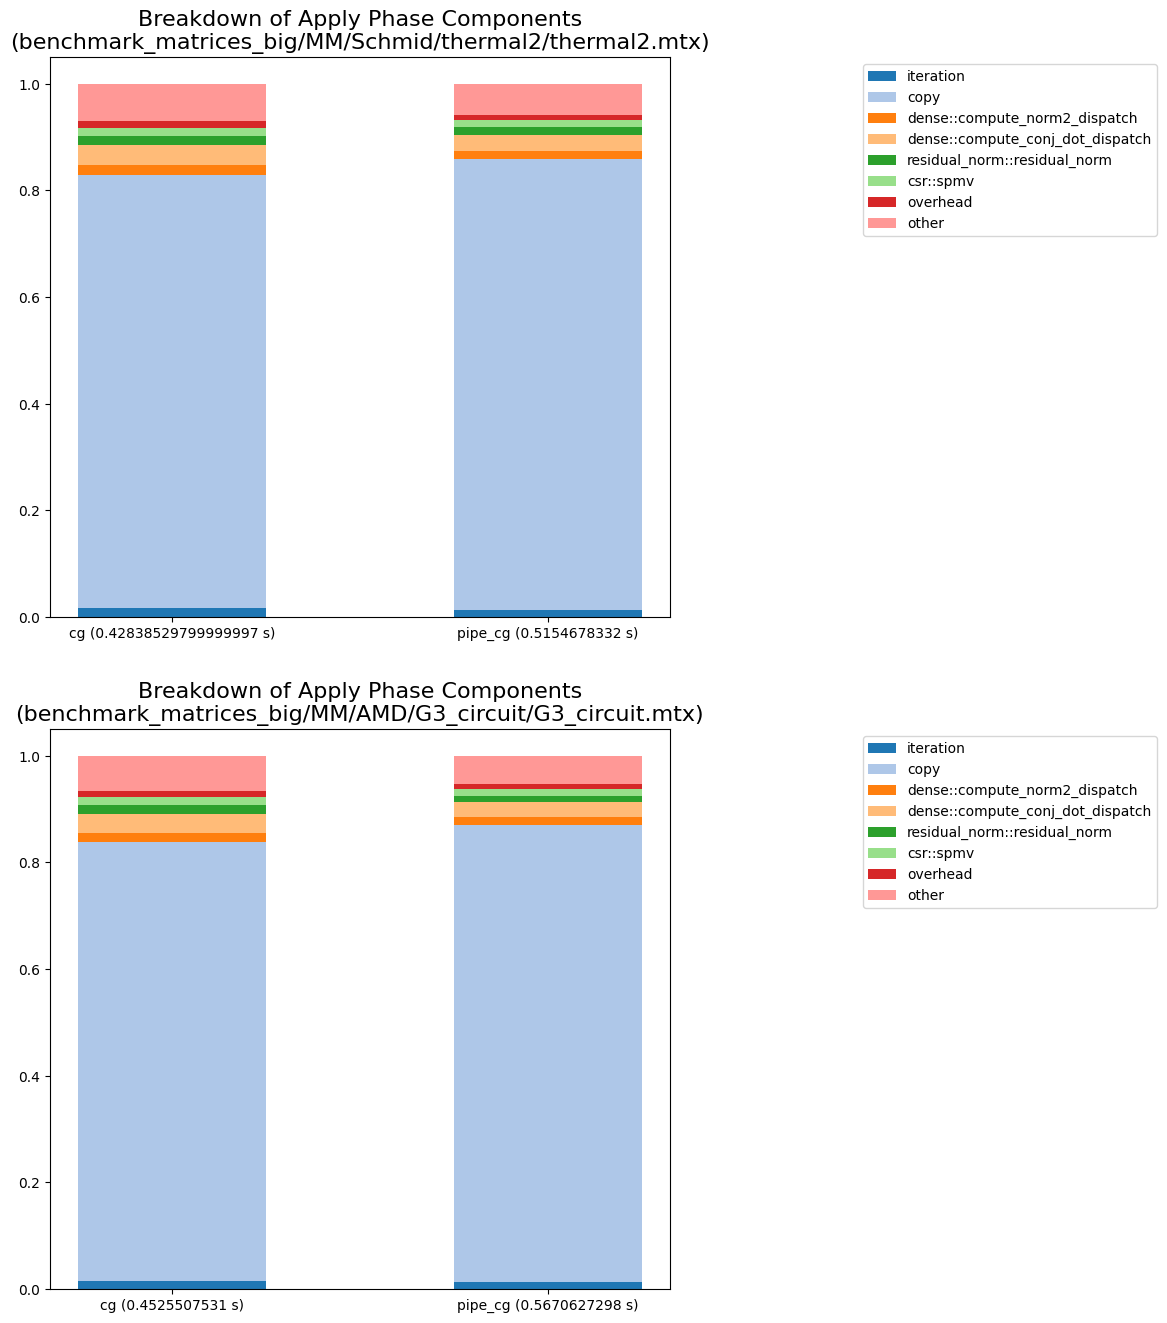

In [11]:
import matplotlib

# bar chart breakups for each solver
solvers_to_plot = ['cg', 'pipe_cg'] 
matrices = [
    "benchmark_matrices_big/MM/Schmid/thermal2/thermal2.mtx",
    "benchmark_matrices_big/MM/AMD/G3_circuit/G3_circuit.mtx",
]
in_fraction = True # better set true, normalises the bar heights

# loop for all matrices
fig, axes = plt.subplots(len(matrices), 1, figsize=(8, 8 * len(matrices))) # Increased size
if num_solvers_to_plot == 1:
    axes = [axes]
plot_idx = 0
for target_filename in matrices:
    barnames = []
    sumtime = np.zeros(len(solvers_to_plot))
    counts = dict()
    width = 0.5
    target_entry = None
    for entry in data:
        if entry["filename"] == target_filename:
            target_entry = entry
            break

    # fill in the counts
    for i_solver in range(len(solvers_to_plot)):
        solver = solvers_to_plot[i_solver]
        if solver in target_entry["solver"]:
            solver_components = target_entry["solver"][solver]["apply"]["components"]
            total_time = 1
            if "time" in target_entry["solver"][solver]["apply"]:
                total_time = target_entry["solver"][solver]["apply"]["time"]
            barnames.append(solver+f" ({total_time} s)")
            for k, v in solver_components.items():
                if k not in counts:
                    counts[k] = np.zeros(len(solvers_to_plot))
                counts[k][i_solver] = v
                sumtime[i_solver] += v
        else:
            print(f"Warning: Solver '{solver_name}' not found for '{target_filename}'.")

    # aggregate the smallest counts into 'other' & normalise
    if "other" not in counts:
        counts["other"] = np.zeros(len(solvers_to_plot))
    to_delete = []
    for k in counts:
        if k == "other":
            continue
        if in_fraction:
            counts[k] = counts[k]/sumtime
        if np.max(counts[k]) < 0.01: # set in_fraction for better results
            counts["other"] += counts[k]
            to_delete.append(k)
    for k in to_delete:
        counts.pop(k)

    # plot
    ax = axes[plot_idx]
    plot_idx += 1
    bottom = np.zeros(len(solvers_to_plot))
    colors = matplotlib.colormaps['tab20']
    ci = 0
    for l, count in counts.items():
        p = ax.bar(barnames, count, width, label=l, bottom=bottom, color=colors(ci))
        bottom += count
        ci += 1

    ax.set_title(f'Breakdown of Apply Phase Components\n({target_filename})', fontsize=16)
    ax.legend(bbox_to_anchor=(1.3, 1.0))

plt.show()

In [12]:
plot_data = {
    'cg': [],
    'pipe_cg': []
}

for entry in data:
    for solver_name in plot_data.keys():
        if solver_name in entry["solver"]:
            solver_info = entry["solver"][solver_name]
            
            iterations = solver_info["apply"]["iterations"]
            generate_time = solver_info["generate"]["time"]
            apply_time = solver_info["apply"]["time"]

            total_time = generate_time + apply_time
            plot_data[solver_name].append((iterations, total_time))

plt.figure(figsize=(10, 7))

markers = {'pipe_cg':'x', 'cg':'o'}

for solver_name, points in plot_data.items():
    if points:
        x_iterations = [p[0] for p in points]
        y_total_times = [p[1] for p in points]
        
        plt.scatter(x_iterations, y_total_times, label=solver_name, marker=markers[solver_name])

plt.xlabel('Iterations')
plt.ylabel('time')
plt.title('Iterations vs. Total Time for Different Matrices and Solvers')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

KeyError: 'iterations'

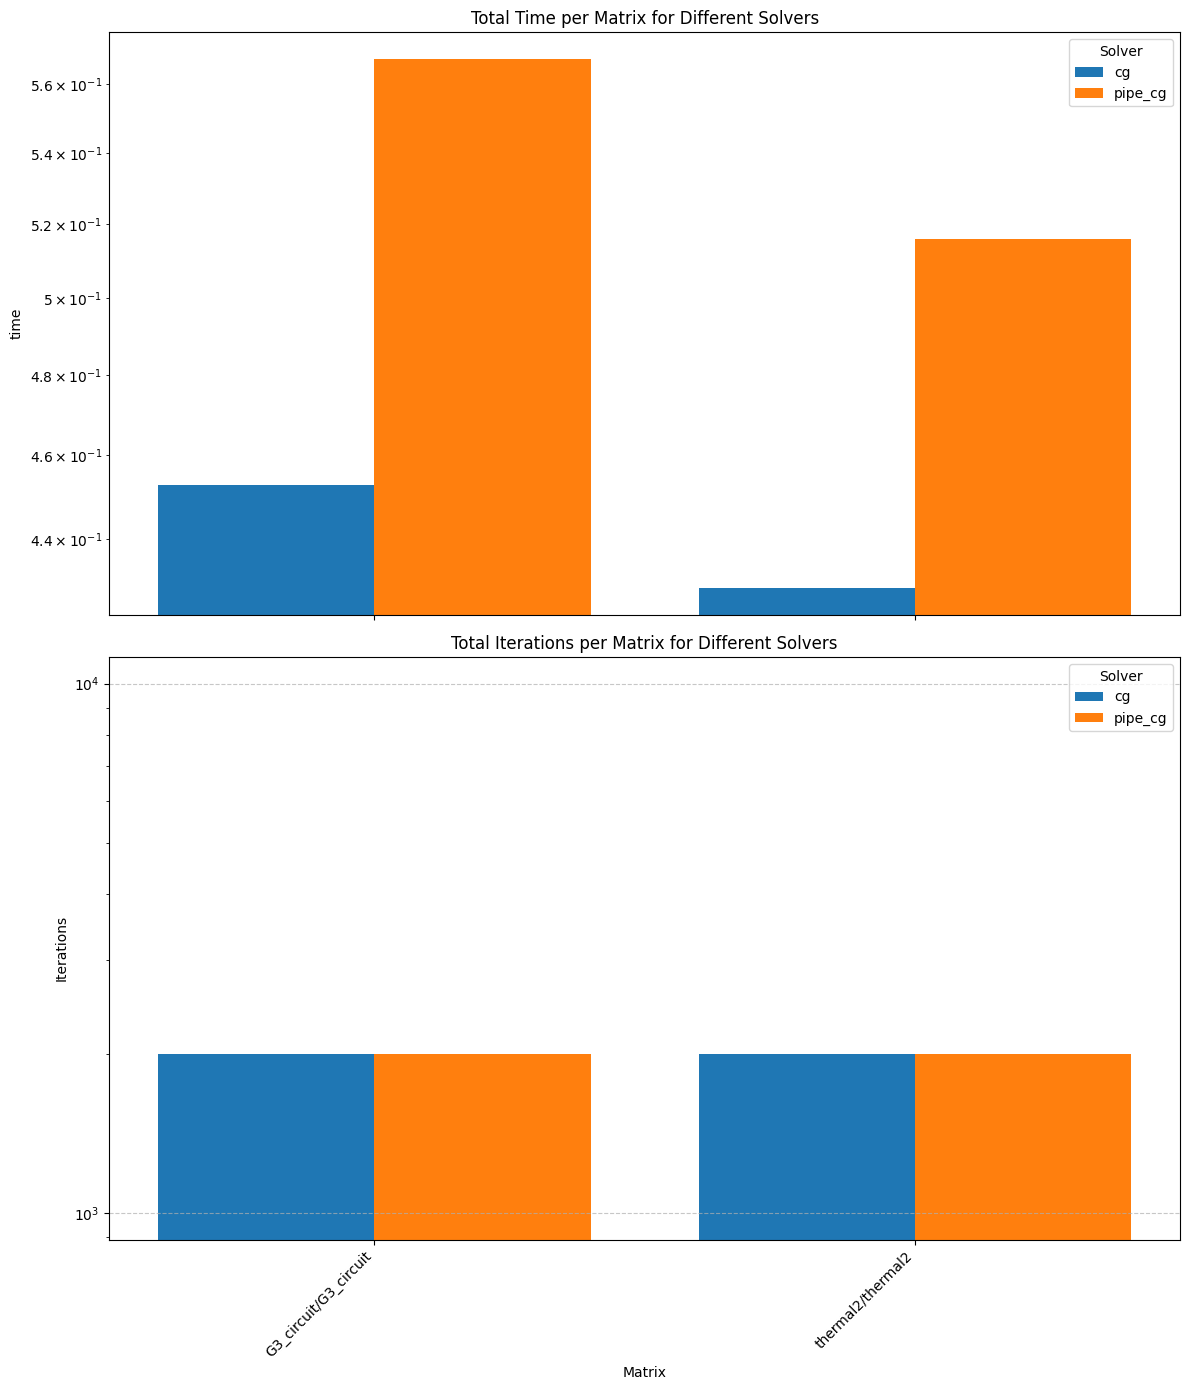

In [13]:
# total iters and total time for different matrices and solvers

solvers_to_plot = ['cg', 'pipe_cg']
matrices = [
    "benchmark_matrices_big/MM/Schmid/thermal2/thermal2.mtx",
    "benchmark_matrices_big/MM/AMD/G3_circuit/G3_circuit.mtx",
]

matrix_solver_times = {}
matrix_solver_iterations = {}

for entry in data:
    filename = entry["filename"]
    if filename not in matrices:
        continue
        
    matrix_base_name = '/'.join(filename.split('/')[-2:]).replace('.mtx', '') 
    
    matrix_solver_times[matrix_base_name] = {}
    matrix_solver_iterations[matrix_base_name] = {}
    
    found_data_for_matrix = False
    for solver_name in solvers_to_plot:
        if solver_name in entry["solver"]:
            solver_info = entry["solver"][solver_name]
                
            generate_time = solver_info["generate"]["time"]
            apply_time = solver_info["apply"]["time"]
            total_time = generate_time + apply_time
            iterations = solver_info["apply"]["iterations"]

            matrix_solver_times[matrix_base_name][solver_name] = total_time
            matrix_solver_iterations[matrix_base_name][solver_name] = iterations
            found_data_for_matrix = True
    
    
    if not found_data_for_matrix:
        del matrix_solver_times[matrix_base_name]
        if matrix_base_name in matrix_solver_iterations:
            del matrix_solver_iterations[matrix_base_name]

matrix_names = sorted(list(matrix_solver_times.keys()))

if not matrix_names:
    print("No valid matrix data found for the specified solvers to create the bar plots.")
else:
    num_matrices = len(matrix_names)
    num_solvers = len(solvers_to_plot)

    bar_width = 0.8 / num_solvers 
    x = np.arange(num_matrices)

    fig, axs = plt.subplots(2, 1, figsize=(max(12, num_matrices * 1.5), 14), sharex=True)

    # plot 1: total time
    ax1 = axs[0]
    for i, solver_name in enumerate(solvers_to_plot):
        times = []
        for matrix_name in matrix_names:
            times.append(matrix_solver_times[matrix_name].get(solver_name, 0)) 
        
        offset = (i - (num_solvers - 1) / 2) * bar_width
        ax1.bar(x + offset, times, bar_width, label=solver_name)

    ax1.set_ylabel('time')
    ax1.set_title('Total Time per Matrix for Different Solvers')
    ax1.set_yscale('log')
    ax1.legend(title="Solver")
    ax1.grid(axis='y', linestyle='--', alpha=0.7) 

    # plot 1: total iters
    ax2 = axs[1]
    for i, solver_name in enumerate(solvers_to_plot):
        iterations = []
        for matrix_name in matrix_names:
            iterations.append(matrix_solver_iterations[matrix_name].get(solver_name, 0)) 
        
        offset = (i - (num_solvers - 1) / 2) * bar_width
        ax2.bar(x + offset, iterations, bar_width, label=solver_name)

    ax2.set_xlabel('Matrix')
    ax2.set_ylabel('Iterations')
    ax2.set_title('Total Iterations per Matrix for Different Solvers')
    ax2.set_yscale('log') 
    ax2.legend(title="Solver")
    ax2.grid(axis='y', linestyle='--', alpha=0.7) 

    plt.xticks(x, matrix_names, rotation=45, ha='right') 
    
    plt.tight_layout()
    plt.show()

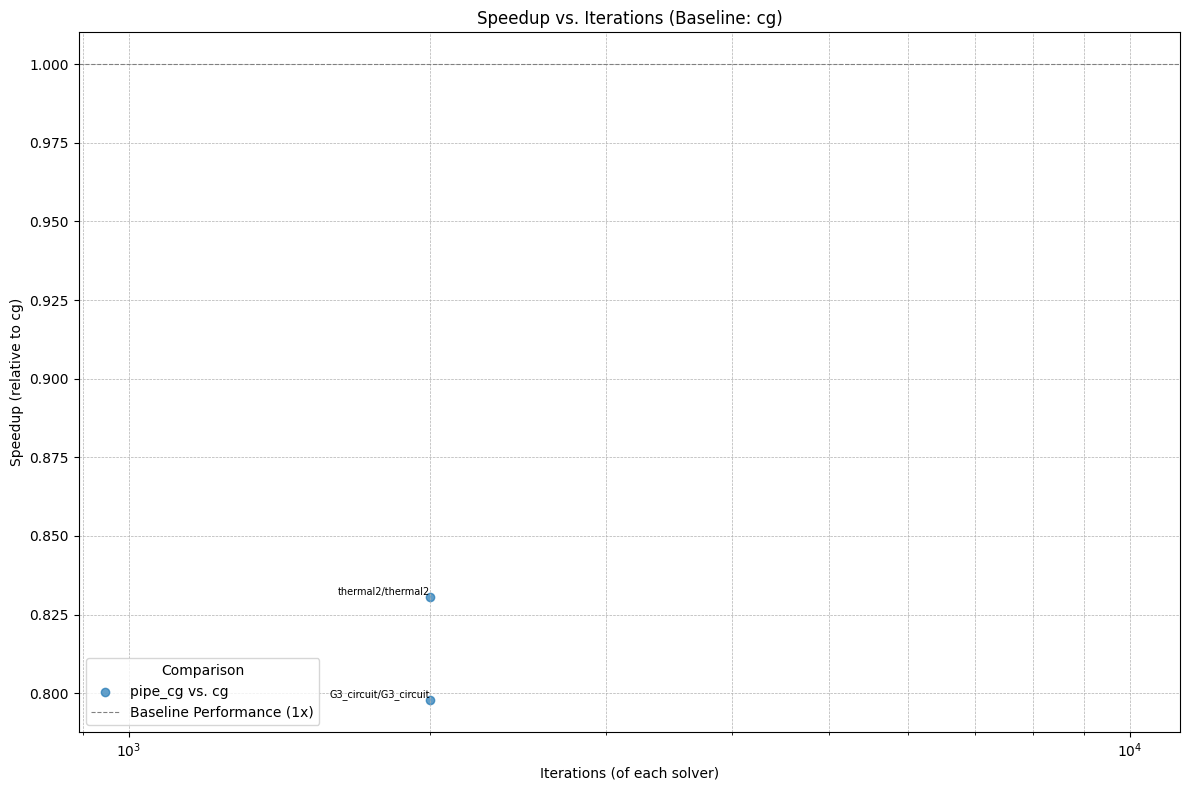

In [14]:
# speedup 
solvers_to_plot = ['cg', 'pipe_cg']

matrices = [
    "benchmark_matrices_big/MM/Schmid/thermal2/thermal2.mtx",
    "benchmark_matrices_big/MM/AMD/G3_circuit/G3_circuit.mtx",
]

matrix_solver_times = {}
matrix_solver_iterations = {}

for entry in data:
    filename = entry["filename"]
    if filename not in matrices:
        continue
        
    matrix_base_name = '/'.join(filename.split('/')[-2:]).replace('.mtx', '') 
    
    matrix_solver_times[matrix_base_name] = {}
    matrix_solver_iterations[matrix_base_name] = {}
    
    for solver_name in solvers_to_plot:
        solver_info = entry["solver"][solver_name]
        
        generate_time = solver_info["generate"]["time"]
        apply_time = solver_info["apply"]["time"]
        total_time = generate_time + apply_time
        iterations = solver_info["apply"]["iterations"]
        
        matrix_solver_times[matrix_base_name][solver_name] = total_time
        matrix_solver_iterations[matrix_base_name][solver_name] = iterations

matrix_names = sorted(list(matrix_solver_times.keys()))

baseline_solver = 'cg'
plot_speedup_data = {}

for matrix_base_name in matrix_names:
    baseline_time = matrix_solver_times[matrix_base_name][baseline_solver]
    
    for solver_name in solvers_to_plot:
        if solver_name == baseline_solver:
            continue
        
        current_solver_time = matrix_solver_times[matrix_base_name][solver_name]
        current_solver_iterations = matrix_solver_iterations[matrix_base_name][solver_name]
        
        speedup = baseline_time / current_solver_time
        
        if solver_name not in plot_speedup_data:
            plot_speedup_data[solver_name] = []
        plot_speedup_data[solver_name].append((current_solver_iterations, speedup, matrix_base_name))

plt.figure(figsize=(12, 8))

for solver_name, points in plot_speedup_data.items():
    x_iterations = [p[0] for p in points]
    y_speedup = [p[1] for p in points]
    matrix_labels = [p[2] for p in points]
    
    plt.scatter(x_iterations, y_speedup, label=f'{solver_name} vs. {baseline_solver}', alpha=0.7)
    
    for i, txt in enumerate(matrix_labels):
        plt.text(x_iterations[i], y_speedup[i], txt, fontsize=7, ha='right', va='bottom')

plt.xlabel(f'Iterations (of each solver)')
plt.ylabel(f'Speedup (relative to {baseline_solver})')
plt.title(f'Speedup vs. Iterations (Baseline: {baseline_solver})')

plt.xscale('log')

plt.axhline(1, color='gray', linestyle='--', linewidth=0.8, label='Baseline Performance (1x)')

plt.legend(title="Comparison")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.show()